In [1]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install tqdm
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from datetime import timedelta
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score


drive.mount('/content/drive')

Mounted at /content/drive


# 모델 추가 학습


In [6]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/StockGeine/datasets/Tesla_aggregated.csv')
stock_df = pd.read_csv('/content/drive/MyDrive/StockGeine/stock/Tesla_stock_dataset.csv')

print(sentiment_df.head())
print(stock_df.head())

  publish_date  positive   neutral  negative    total
0   2024-11-02  0.306029  0.550115  0.143856  neutral
1   2024-11-03  0.399332  0.550568  0.050100  neutral
2   2024-11-04  0.343850  0.533567  0.122583  neutral
3   2024-11-05  0.267738  0.531631  0.200631  neutral
4   2024-11-06  0.377789  0.442457  0.179753  neutral
                        Date        Open        High         Low       Close  \
0  2023-11-24 00:00:00-05:00  233.750000  238.750000  232.330002  235.449997   
1  2023-11-27 00:00:00-05:00  236.889999  238.330002  232.100006  236.080002   
2  2023-11-28 00:00:00-05:00  236.679993  247.000000  234.009995  246.720001   
3  2023-11-29 00:00:00-05:00  249.210007  252.750000  242.759995  244.139999   
4  2023-11-30 00:00:00-05:00  245.139999  245.220001  236.910004  240.080002   

      Volume  Dividends  Stock Splits  
0   65125200        0.0           0.0  
1  112031800        0.0           0.0  
2  148549900        0.0           0.0  
3  135401300        0.0           0

In [7]:
# 날짜 형식 변환
sentiment_df['publish_date'] = pd.to_datetime(sentiment_df['publish_date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True).dt.date
sentiment_df['publish_date'] = sentiment_df['publish_date'].dt.date  # 날짜만 남김

# 열 이름 변경 (병합을 위해)
sentiment_df.rename(columns={'publish_date': 'Date'}, inplace=True)

# 데이터 병합
data = pd.merge(stock_df, sentiment_df, on='Date', how='inner')
data['Date'] = pd.to_datetime(data['Date']).dt.date


# 병합된 데이터 확인
print("\nMerged DataFrame Head:")
print(data.head())


data.drop(['Dividends', 'Stock Splits', 'total'], axis=1, inplace=True)

print("\nMissing values in each column:")
print(data.isnull().sum())

total = data['positive'] + data['neutral'] + data['negative']
data['p_positive'] = data['positive'] / total
data['p_negative'] = data['negative'] / total
data['sentiment_score'] = data['p_positive'] - data['p_negative']


# 다음 날 종가 생성
data['Next_Close'] = data['Close'].shift(-1)

# 마지막 행 제거 (다음 날 종가가 없으므로)
data = data[:-1]

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_score']
X = data[features]

# 라벨 설정
y = data['Next_Close']


Merged DataFrame Head:
         Date        Open        High         Low       Close     Volume  \
0  2024-11-04  244.559998  248.899994  238.880005  242.839996   68802400   
1  2024-11-05  247.339996  255.279999  246.210007  251.440002   69282500   
2  2024-11-06  284.670013  289.589996  275.619995  288.529999  165228700   
3  2024-11-07  288.890015  299.750000  285.519989  296.910004  117309200   
4  2024-11-08  299.140015  328.709991  297.660004  321.220001  204782800   

   Dividends  Stock Splits  positive   neutral  negative     total  
0        0.0           0.0  0.343850  0.533567  0.122583   neutral  
1        0.0           0.0  0.267738  0.531631  0.200631   neutral  
2        0.0           0.0  0.377789  0.442457  0.179753   neutral  
3        0.0           0.0  0.449186  0.449856  0.100958   neutral  
4        0.0           0.0  0.471812  0.466910  0.061278  positive  

Missing values in each column:
Date        0
Open        0
High        0
Low         0
Close       0
Vol

In [8]:
############### 데이터 분할 (80% / 20% or 70% / 30%) ######################
X_new_train, X_test, y_new_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

########## 모델 불러오기
xgb_reg_loaded = xgb.Booster()
xgb_reg_loaded.load_model('/content/drive/MyDrive/Colab Notebooks/en_pr_model.json')

#기존 모델이 제대로 로드되었는지 확인하기 위해, 모델 로드 후 저장된 트리 개수를 출력
print(f"Number of trees before additional training: {len(xgb_reg_loaded.get_dump())}")


# 하이퍼파라미터 설정
params = {
    'max_depth': 5,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

dnew_train = xgb.DMatrix(X_new_train, label=y_new_train)  # 추가 학습 데이터
dtest = xgb.DMatrix(X_test)


# 기존 모델에 추가 학습 (num_boost_round는 추가할 트리 개수)
model = xgb.train(params, dnew_train, num_boost_round=50, xgb_model=xgb_reg_loaded)

#추가 학습 후에도 트리 개수가 적절히 증가
print(f"Number of trees after additional training: {len(model.get_dump())}")

Number of trees before additional training: 100
Number of trees after additional training: 150


In [9]:
# 테스트 세트 예측
y_pred = model.predict(dtest)

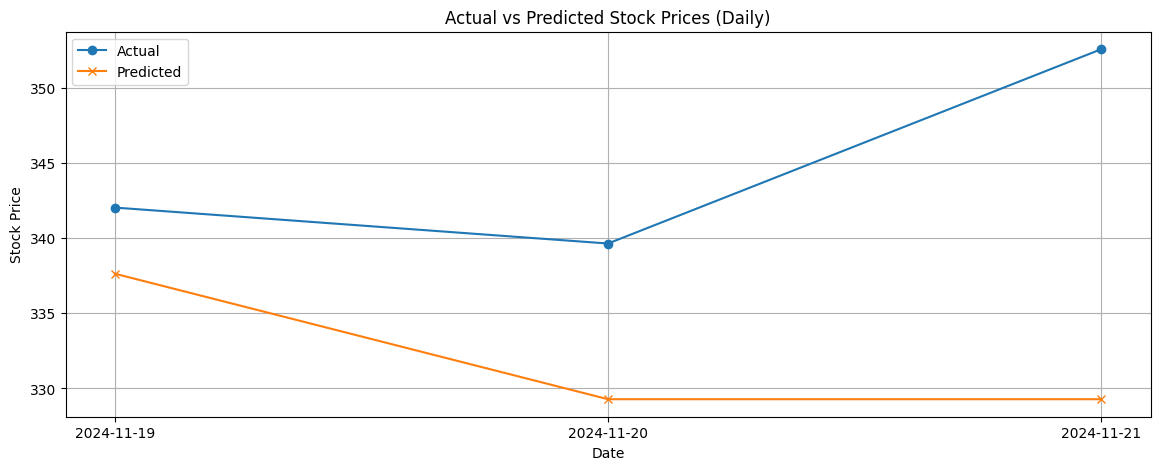

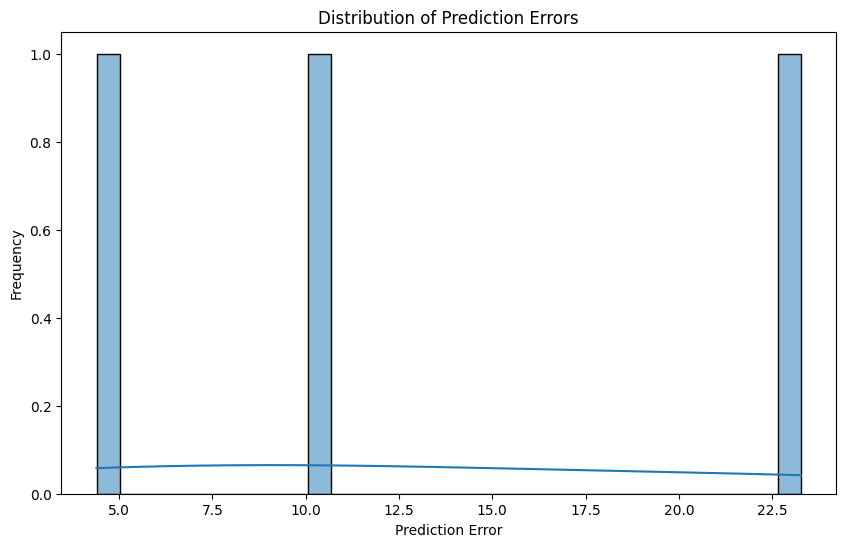

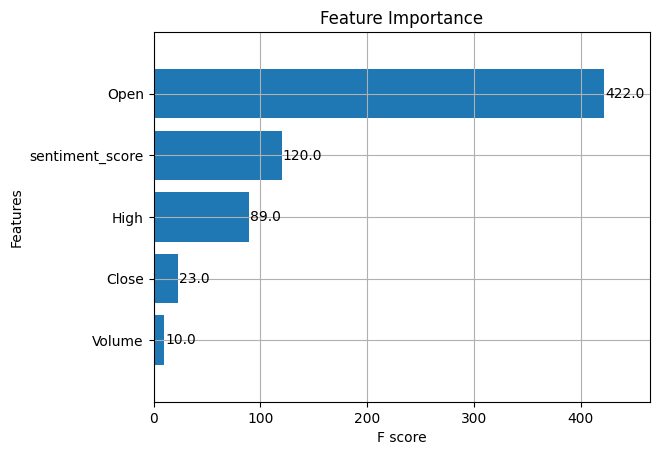

RMSE: 14.92
MAE: 12.67
R² Score: -6.07


주가 방향성 예측 정확도: 66.67%

혼동 행렬:
[[2 0]
 [1 0]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

         Date  Previous_Close  Actual_Next_Close  Predicted_Next_Close  \
0  2024-11-19      346.000000         342.029999            337.632812   
1  2024-11-20      342.029999         339.640015            329.286255   
2  2024-11-21      339.640015         352.559998            329.286255   

   Actual_Movement  Predicted_Movement  
0                0                   0  
1                0                   0  
2                1                   0  


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
dates = data['Date'].iloc[y_new_train.shape[0]:].reset_index(drop=True) # 날짜만 가져옴

# 결과 데이터프레임 생성
results = pd.DataFrame({'Date': dates, 'Actual': y_test.reset_index(drop=True), 'Predicted': y_pred})

# 'Date' 열을 datetime 형식으로 변환
results['Date'] = pd.to_datetime(results['Date'])
results.set_index('Date', inplace=True)


######################## 날짜 기준 그래프 시각화
plt.figure(figsize=(14, 5))
plt.plot(results['Actual'], label='Actual', marker='o')
plt.plot(results['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Stock Prices (Daily)')
plt.xlabel('Date')
plt.ylabel('Stock Price')


plt.xticks(results.index)  # 결과 데이터프레임의 인덱스를 x축 틱으로 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 날짜 포맷 지정

plt.legend()
plt.grid()
plt.show()
######################## 히스토그램으로 오차 분포 시각화
errors = y_test.values - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.show()
######################## 특징 중요도 가져오기
xgb.plot_importance(model, height=0.8)
plt.title('Feature Importance')

plt.show()

######################## 성능 평가
# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

# R² 스코어 계산
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")
print()

# 테스트 데이터에서 이전 날의 종가 가져오기
previous_close = data['Close'].iloc[y_new_train.shape[0]:].reset_index(drop=True)

# 실제 방향성 계산 (다음 날 종가 - 이전 날 종가)
actual_direction = y_test.reset_index(drop=True) - previous_close

# 예측된 방향성 계산 (예측된 다음 날 종가 - 이전 날 종가)
predicted_direction = y_pred - previous_close

# 실제 방향성 이진화
actual_movement = np.where(actual_direction > 0, 1, 0)

# 예측된 방향성 이진화
predicted_movement = np.where(predicted_direction > 0, 1, 0)

# 정확도 계산
accuracy = accuracy_score(actual_movement, predicted_movement)

print(f"\n주가 방향성 예측 정확도: {accuracy * 100:.2f}%")

# 혼동 행렬
conf_matrix = confusion_matrix(actual_movement, predicted_movement)
print("\n혼동 행렬:")
print(conf_matrix)

# 분류 보고서
class_report = classification_report(actual_movement, predicted_movement)
print("\n분류 보고서:")
print(class_report)

res = pd.DataFrame({
    'Date': dates,
    'Previous_Close': previous_close,
    'Actual_Next_Close': y_test.reset_index(drop=True),
    'Predicted_Next_Close': y_pred,
    'Actual_Movement': actual_movement,
    'Predicted_Movement': predicted_movement
})

print(res)


In [11]:
# 영어
model.save_model('en_predict_model.json')

# 한국
# model.save_model('kor_pr_model_up.json')

# 모델 예측 수행 (실제 예측)


Last available market date: 2024-11-24
Recent 7 days data:
           Date     Close
238  2024-11-18  305500.0
239  2024-11-19  308000.0
240  2024-11-20  307000.0
241  2024-11-21  308500.0
242  2024-11-24  307000.0
Next prediction date: 2024-11-25
1004091.4


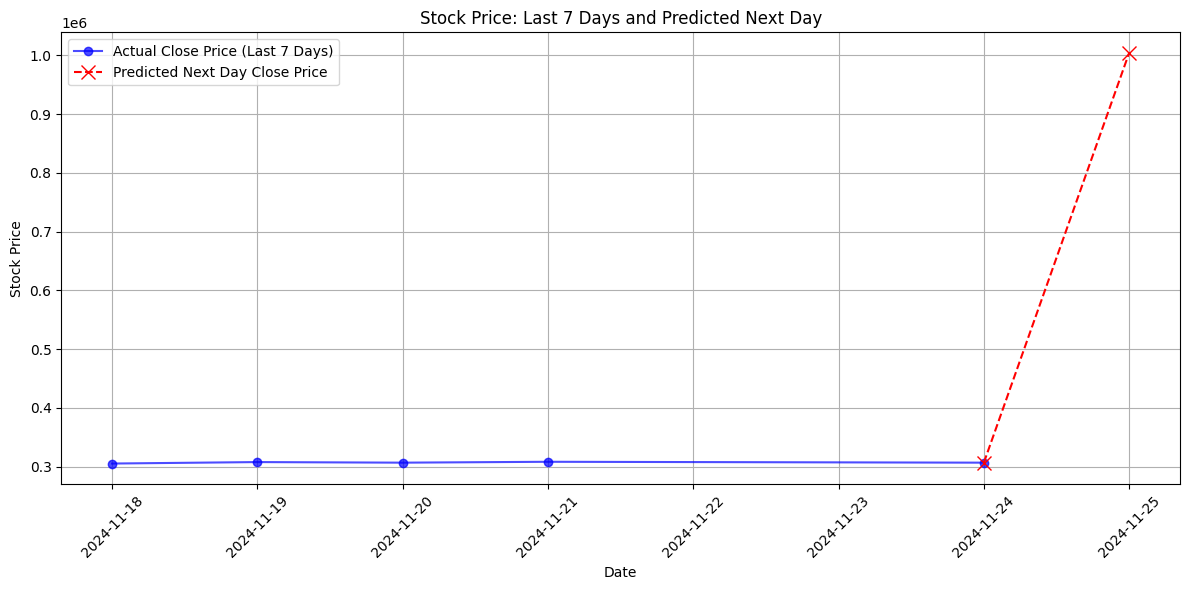

In [ ]:
# 데이터 로드
new_sentiment_df = pd.read_csv('/content/drive/MyDrive/StockGeine/datasets/크래프톤_aggregated.csv')
new_stock_df = pd.read_csv('/content/drive/MyDrive/StockGeine/stock/크래프톤_stock_dataset.csv')

# 날짜 형식 변환 (UTC 설정 추가)
new_sentiment_df['publish_date'] = pd.to_datetime(new_sentiment_df['publish_date'], utc=True)
new_stock_df['Date'] = pd.to_datetime(new_stock_df['Date'], utc=True)

# 날짜 형식을 date만 남기도록 설정
new_sentiment_df['Date'] = new_sentiment_df['publish_date'].dt.date
new_stock_df['Date'] = new_stock_df['Date'].dt.date

# 감성 데이터 병합 (기준: new_stock_df)
new_data = pd.merge(new_stock_df, new_sentiment_df, on='Date', how='left')

# 감성 데이터 결측치 처리
new_data['positive'] = new_data['positive'].fillna(0)
new_data['negative'] = new_data['negative'].fillna(0)
new_data['sentiment_score'] = new_data['positive'] - new_data['negative']

# 필요 없는 열 제거
new_data.drop(['Dividends', 'Stock Splits', 'total'], axis=1, errors='ignore', inplace=True)

# 가장 최신 날짜 확인
last_available_date = new_data['Date'].max()
print(f"Last available market date: {last_available_date}")

# 최근 7일간의 주가 데이터 가져오기
recent_7_days_data = new_data[new_data['Date'] > last_available_date - timedelta(days=7)]
print(f"Recent 7 days data:\n{recent_7_days_data[['Date', 'Close']]}")

# 다음 예측 날짜 계산
if last_available_date.weekday() == 4:  # 금요일
    predict_date = last_available_date + timedelta(days=3)  # 월요일
else:
    predict_date = last_available_date + timedelta(days=1)

print(f"Next prediction date: {predict_date}")

# 특징 설정
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_score']
X_predict = new_data[new_data['Date'] == last_available_date][features]

if X_predict.empty:
    print(f"No data available for the date: {last_available_date}")
else:
    # DMatrix 변환 시 feature_names 명시적 설정
    d_predict = xgb.DMatrix(X_predict, feature_names=features)

    # 저장된 모델 로드
    predict_model = xgb.Booster()
    predict_model.load_model('updated_kor_model.json')

    # 다음 날 종가 예측
    predicted_price = predict_model.predict(d_predict)

    # 다음 날 주가 데이터를 예측 결과로 생성
    future_data = pd.DataFrame({
        'Date': [predict_date],
        'Close': [predicted_price[0]]
    })

    print(predicted_price[0])

    # 최근 7일 데이터에 예측 데이터 추가
    combined_data = pd.concat([recent_7_days_data[['Date', 'Close']], future_data], ignore_index=True)

    # 시각화 - 실제 주가와 예측된 주가
    plt.figure(figsize=(12, 6))

    # 최근 7일간의 실제 주가
    plt.plot(combined_data['Date'][:-1], combined_data['Close'][:-1], label='Actual Close Price (Last 7 Days)', color='blue', marker='o', linestyle='-', alpha=0.7)

    # 예측된 다음 날 주가
    plt.plot(combined_data['Date'][-2:], combined_data['Close'][-2:], label='Predicted Next Day Close Price', color='red', linestyle='--', marker='x', markersize=10)

    # 그래프 장식
    plt.title('Stock Price: Last 7 Days and Predicted Next Day')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45)
    plt.grid(visible=True)
    plt.legend()
    plt.tight_layout()

    # 그래프 표시
    plt.show()